In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets,transforms
from torch.utils.data.sampler import RandomSampler

In [7]:
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('/home/vikrant/.pytorch/Cifar10/',train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('/home/vikrant/.pytorch/Cifar10/',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
#split train dataset into train and valid set
indices = list(range(len(train_data)))
np.random.shuffle(indices)
valid_size = int(np.float(len(train_data)*valid_size))
train_indices,valid_indices = indices[valid_size:],indices[:valid_size]

# define samplers for obtaining training and validation batches
train_sampler = RandomSampler(train_indices)
valid_sampler = RandomSampler(valid_indices)

#define train ,valid and test loader
trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler)
testloader  = torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [9]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

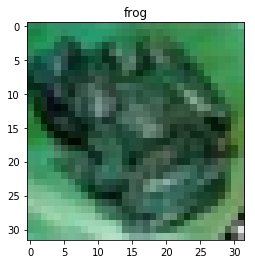

In [11]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

imshow(images[0])
plt.title(classes[labels[0]])
plt.show()

In [36]:
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        #Input size --> 32X32X3
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        #Input size --> 32X32X16
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        #Input size --> 32X32X32
        self.maxpool1 = nn.MaxPool2d(2,2)
        #Input size --> 16X16X32
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        #Input size --> 16X16X64
        self.conv4 = nn.Conv2d(64,64,3,padding=1)
        #Input size --> 16X16X64
        self.maxpool2 = nn.MaxPool2d(2,2)
        #Input size --> 8X8X64
        self.conv5 = nn.Conv2d(64,128,3)
        #Input size --> 6X6X128
        self.conv6 = nn.Conv2d(128,256,3)
        #Input size --> 4X4X256
        self.maxpool3 = nn.MaxPool2d(2,2)
        #Input size --> 2X2X256
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256*4,256)
        self.fc2 = nn.Linear(256,10)
        
        
    def forward(self,x):
        x =  F.relu(self.conv1(x))
        x =  F.relu(self.conv2(x))
        x =  self.maxpool1(x)
        
        x =  F.relu(self.conv3(x))
        x =  F.relu(self.conv4(x))
        x =  self.maxpool2(x)
        
        x =  F.relu(self.conv5(x))
        x =  F.relu(self.conv6(x))
        x =  self.maxpool3(x)
        
        x = x.view(-1,256*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = F.log_softmax(self.fc2(x))
        
        return x
    
model = Network()
model
        
        
        
        

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
train_on_cuda = torch.cuda.is_available()
train_on_cuda

True

In [38]:
if train_on_cuda:
    model.cuda()
    
device = torch.device("cuda" if train_on_cuda else "cpu")
device

device(type='cuda')

In [39]:
#define loss and optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),lr=0.003)
criterion = nn.NLLLoss()



In [40]:
epochs = 30
valid_loss_min = np.Inf
train_loss_list =[]
valid_loss_list =[]
for e in range(1,epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    acc = 0
    for images,labels in trainloader:
        #move images ,labels to gpu
        images,labels = images.to(device),labels.to(device)
        #clear all gradient
        optimizer.zero_grad()
        #feed forward along model to get log softmax
        ps_log = model.forward(images)
        #compute loss
        loss = criterion(ps_log,labels)
        #compute gradient
        loss.backward()
        #do one optimizer step
        optimizer.step()
        
        train_loss += loss.item()
    else:
        #turn off auto grad
        with torch.no_grad():
            #run model in eval mode
            model.eval()
            for images,labels in validloader:
                #move variables to gpu
                images,labels = images.to(device),labels.to(device)
                #compute model prediction 
                ps_log = model.forward(images)
                ps = torch.exp(ps_log)
                #compute loss
                loss = criterion(ps_log,labels)
                valid_loss += loss.item()
                
                _,top_class = ps.topk(1,dim=1)
                
                equal = top_class == labels.view(*top_class.shape)
                acc += torch.mean(equal.type(torch.FloatTensor)).item()
            model.train()
    train_loss = train_loss / len(trainloader)
    valid_loss = valid_loss / len(validloader)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    print("Epoch : {}/{}".format(e,epochs),
         "\t Accuracy : {:.3f}".format((acc/len(validloader))*100),
         "\t Train Loss: {:.3f}".format(train_loss),
         "\t Test Loss: {:.3f}".format(valid_loss))
    if valid_loss < valid_loss_min:
        print("Saving model ...",
             "\n Min loss at previous epochs {:.3f}".format(valid_loss_min),
             "\t Loss at current epoch {:.3f}".format(valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
    
        
                
                
        
        
        
        
        

/home/vikrant/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 1/30 	 Accuracy : 39.800 	 Train Loss: 1.868 	 Test Loss: 1.643
Saving model ... 
 Min loss at previous epochs inf 	 Loss at current epoch 1.643
Epoch : 2/30 	 Accuracy : 49.270 	 Train Loss: 1.535 	 Test Loss: 1.402
Saving model ... 
 Min loss at previous epochs 1.643 	 Loss at current epoch 1.402
Epoch : 3/30 	 Accuracy : 48.970 	 Train Loss: 1.456 	 Test Loss: 1.411
Epoch : 4/30 	 Accuracy : 54.200 	 Train Loss: 1.407 	 Test Loss: 1.270
Saving model ... 
 Min loss at previous epochs 1.402 	 Loss at current epoch 1.270
Epoch : 5/30 	 Accuracy : 51.610 	 Train Loss: 1.371 	 Test Loss: 1.339
Epoch : 6/30 	 Accuracy : 55.970 	 Train Loss: 1.339 	 Test Loss: 1.237
Saving model ... 
 Min loss at previous epochs 1.270 	 Loss at current epoch 1.237
Epoch : 7/30 	 Accuracy : 56.970 	 Train Loss: 1.307 	 Test Loss: 1.192
Saving model ... 
 Min loss at previous epochs 1.237 	 Loss at current epoch 1.192
Epoch : 8/30 	 Accuracy : 58.190 	 Train Loss: 1.287 	 Test Loss: 1.156
Saving mode

In [47]:
model.load_state_dict(torch.load('model_cifar.pt'))

/home/vikrant/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


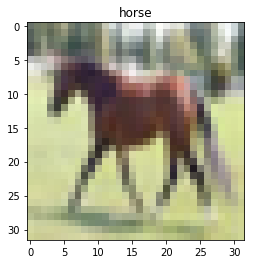

In [61]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
############
#prediction#
###########
images = images.to(device)
log_ps = model.forward(images)
ps = model.forward(images)
_,top_class = ps.topk(1,dim=1)
top_class = top_class.to(torch.device("cpu"))
images = images.to(torch.device("cpu"))

top_class = top_class.numpy() #convert prediction from tensor to numpy array
top_class = np.squeeze(top_class)
images = images.numpy() # convert images to numpy for display
#print(top_class)
imshow(images[5])
plt.title(classes[top_class[5]])
plt.show()
